# ASC speed into the binned heat transport grid

Code to bin the new ASC speed calculated in teh XY grid (cell faces), into the  binned locations of the HT, THe final objective here is to have the same points as the HT, for point-by-point correlation 

In [1]:
%matplotlib inline
# Standard modules
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import netCDF4 as nc
import seaborn as sns
import xarray as xr
import numpy as np
import os
from dask.distributed import Client
# Optional modules
import xgcm
# Ignore warnings
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

In [2]:
client = Client() # n_workers=4

In [3]:
#importing [Monthly] ASC speed from year 2095 to 2098
import glob
src = '/g/data/x77/wf4500/ASC_project/ASC_speed/daily_z/OM2_IAF_XYgrid/Antarctic_slope_contour_1km_velocities_*'
gl =glob.glob(src + "****_uv.nc")
gl=sorted(gl); gl
print("%i netcdf data files"%len(gl))
##importing data from ocean.nc
Along_slope_v=xr.open_mfdataset(gl, concat_dim='time', combine='nested').mean('time')
Along_slope_v_time=xr.open_mfdataset(gl, concat_dim='time', combine='nested')

732 netcdf data files


In [4]:
start_time='1958-01-01'
end_time='1958-01-31'
Along_slope_v_time = Along_slope_v_time.sel(time=slice(start_time,end_time))
ndays=np.size(Along_slope_v_time.time)
ndays

31

### Binning speeds into the HT binned grid

In [5]:
lon_along_contour=np.array(Along_slope_v_time.lon_along_contour.isel(time=0))
lat_along_contour=np.array(Along_slope_v_time.lat_along_contour.isel(time=0))

In [6]:
%%time
Along_slope_v_time=Along_slope_v_time.load()

CPU times: user 822 ms, sys: 221 ms, total: 1.04 s
Wall time: 4.66 s


In [7]:
Along_slope_v_time

<xarray.Dataset>
Dimensions:                 (st_ocean: 75, time: 31, contour_index: 6002)
Coordinates:
  * st_ocean                (st_ocean) float64 0.5413 1.681 ... 5.709e+03
  * time                    (time) datetime64[ns] 1958-01-01T12:00:00 ... 195...
  * contour_index           (contour_index) int64 1 2 3 4 ... 6000 6001 6002
Data variables:
    u_along_contour         (time, st_ocean, contour_index) float32 0.04414 ....
    u_cross_contour         (time, st_ocean, contour_index) float32 0.004249 ...
    lon_along_contour       (time, contour_index) float64 -279.9 -279.8 ... 80.0
    lat_along_contour       (time, contour_index) float64 -66.01 ... -66.03
    thickness_contour       (time, st_ocean, contour_index) float64 1.083 ......
    distance_along_contour  (time, contour_index) float64 4.539 4.539 ... 5.112

Binning surface speed

In [8]:
	# convert to longitude coordinate and average into 3 degree longitude bins:
	# in degrees:
	bin_width = 3
	bin_spacing = 0.25
	lon_west = -280
	lon_east = 80
	
	surf_U=Along_slope_v_time.u_along_contour.isel(st_ocean=0,time=0)
	
	# new coordinate and midpoints of longitude bins:
	full_lon_coord = np.arange(lon_west,lon_east+bin_spacing,bin_spacing)
	lon_bin_midpoints = np.arange(lon_west+bin_width/2,lon_east-bin_width/2,bin_spacing)
	n_bin_edges = len(full_lon_coord)
	
	# sum into longitude bins:
	# need to be very careful of loops, we can't just mask over longitude values, but instead pick indices 
	# on the isobath contour and sum continously along contour between defined indices.
	# (i.e. lon_along_contour is not monotonic)
	# find points on contour to define edges of longitude bins:
	bin_edge_indices = np.zeros(n_bin_edges)
	for lon_bin in range(n_bin_edges-1):
	    # find first isobath point that has the right longitude:
	    first_point = np.where(lon_along_contour>=full_lon_coord[lon_bin])[0][0]
	    # then find all other isobath points with the same longitude as that first point:
	    same_lon_points = np.where(lon_along_contour==lon_along_contour[first_point])[0]
	    # we want the most southerly of these points on the same longitude line:
	    bin_edge_indices[lon_bin] = same_lon_points[np.argmin(lat_along_contour[same_lon_points])]
	    
	# define east/west edges:
	bin_edge_indices = bin_edge_indices.astype(int)
	bin_edge_indices_west = bin_edge_indices[:-int(bin_width/bin_spacing)-1]
	bin_edge_indices_east = bin_edge_indices[int(bin_width/bin_spacing):-1]
	n_bins = len(bin_edge_indices_west)
	
	# # sum heat transport from isobath coord into new longitude coord:
	# surf_U_binned = np.zeros(n_bins)
	# for lon_bin in range(n_bins):
	#     surf_U_this_bin = surf_U[bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
	#     surf_U_binned[lon_bin] = np.mean(surf_U_this_bin)
	    
	# find average latitude of each bin, so we can plot back on the isobath:
	lat_bin_midpoints = np.zeros(n_bins)
	for lon_bin in range(n_bins):
	    # find nearest isobath point:
	    lon_index = np.where(lon_along_contour>=lon_bin_midpoints[lon_bin])[0][0]
	    lat_bin_midpoints[lon_bin] = lat_along_contour[lon_index]

**Comment cell below if speed is already binned**

In [9]:
        from joblib import Parallel, delayed
        def binning_Ualong(Along_slope_v_time,lon_along_contour,lat_along_contour, nn):
        	#nn will be ii*jj, just to make the paralelizarion more efficient    
        	#defining ii and tt
        	iilist=np.tile(np.arange(75),31)
        	ttlist=np.sort(np.tile(np.arange(31),75))  
        	# convert to longitude coordinate and average into 3 degree longitude bins:
        	# in degrees:
        	bin_width = 3
        	bin_spacing = 0.25
        	lon_west = -280
        	lon_east = 80
        	
        	ii=iilist[nn];tt=ttlist[nn]
        	surf_U=Along_slope_v_time.u_along_contour.isel(st_ocean=ii,time=tt)
        	
        	# new coordinate and midpoints of longitude bins:
        	full_lon_coord = np.arange(lon_west,lon_east+bin_spacing,bin_spacing)
        	lon_bin_midpoints = np.arange(lon_west+bin_width/2,lon_east-bin_width/2,bin_spacing)
        	n_bin_edges = len(full_lon_coord)
        	
        	# sum into longitude bins:
        	# need to be very careful of loops, we can't just mask over longitude values, but instead pick indices 
        	# on the isobath contour and sum continously along contour between defined indices.
        	# (i.e. lon_along_contour is not monotonic)
        	# find points on contour to define edges of longitude bins:
        	bin_edge_indices = np.zeros(n_bin_edges)
        	for lon_bin in range(n_bin_edges-1):
        	    # find first isobath point that has the right longitude:
        	    first_point = np.where(lon_along_contour>=full_lon_coord[lon_bin])[0][0]
        	    # then find all other isobath points with the same longitude as that first point:
        	    same_lon_points = np.where(lon_along_contour==lon_along_contour[first_point])[0]
        	    # we want the most southerly of these points on the same longitude line:
        	    bin_edge_indices[lon_bin] = same_lon_points[np.argmin(lat_along_contour[same_lon_points])]
        	    
        	# define east/west edges:
        	bin_edge_indices = bin_edge_indices.astype(int)
        	bin_edge_indices_west = bin_edge_indices[:-int(bin_width/bin_spacing)-1]
        	bin_edge_indices_east = bin_edge_indices[int(bin_width/bin_spacing):-1]
        	n_bins = len(bin_edge_indices_west)
        	
        	# sum heat transport from isobath coord into new longitude coord:
        	surf_U_binned = np.zeros(n_bins)
        	for lon_bin in range(n_bins):
        	    surf_U_this_bin = surf_U[bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
        	    surf_U_binned[lon_bin] = np.mean(surf_U_this_bin)
        
        	        
        	return surf_U_binned

It would take 3 hours to run the binning for all depths in one timeframe if the binning is run in just one core. It would be almost impossible to do it for all times in the jupyter notebook. So we will run the loop in paralel to be faster.

In [10]:
%%time
surf_U_binned = Parallel(n_jobs=-1)(delayed(binning_Ualong)(Along_slope_v_time,lon_along_contour,lat_along_contour, nn) for nn in range(75*ndays))



CPU times: user 35.1 s, sys: 6.75 s, total: 41.9 s
Wall time: 9min 23s


it took 7.3 min to run 28 cases. for 56 cases it took  14.09 min. Therefore, for 1 year (365 cases), this will take. XXX min. Based on this value, 1 year of daily data would take 1.5 hours at least, so this gotta be run on the queue.

In [11]:
surf_U_binned_3d=np.reshape(surf_U_binned,[ndays,75,1428]);
np.shape(surf_U_binned_3d)

(31, 75, 1428)

(1200.0, 0.0)

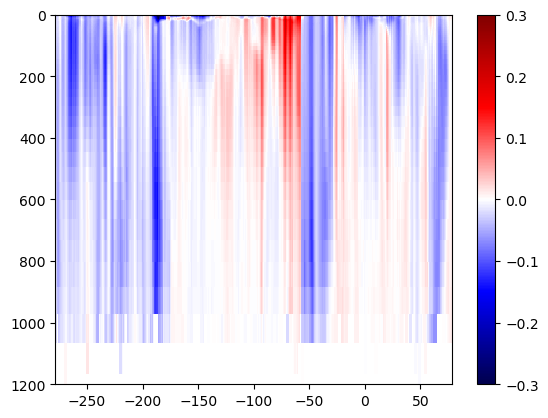

In [12]:
#test plot
plt.pcolormesh(lon_bin_midpoints,Along_slope_v_time.st_ocean,surf_U_binned_3d[0],cmap='seismic',vmin=-0.3,vmax=0.3)
plt.colorbar()
plt.ylim(1200,0)


Lets save the interpolated dataset

In [25]:
		save_dir='/home/156/wf4500'
		data_along=xr.DataArray((surf_U_binned_3d),name="u_along_contour_binned",dims=["time","st_ocean","lon_bin_midpoints"])
		data_lat=xr.DataArray((lat_bin_midpoints),name="lat_bin_midpoints",dims=["lon_bin_midpoints"])



		
		data_to_saveuv = xr.merge([data_along,data_lat])
		data_to_saveuv['st_ocean']=Along_slope_v_time.st_ocean
		data_to_saveuv['time']=Along_slope_v_time.time
		data_to_saveuv['lon_bin_midpoints']=lon_bin_midpoints
		data_to_saveuv
		data_to_saveuv.to_netcdf(save_dir +"/test.nc")



